<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Quest6/Ex12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#12. 뉴스 요약봇 만들기 [프로젝트]

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.	
>분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.	
>모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해 보았다.	
>두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

라이브러리

In [1]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230525")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230525'

In [ ]:
!pip install summa

In [64]:
import tensorflow

import re
from importlib.metadata import version
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import summa
from summa import summarizer
from summa.summarizer import summarize

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step1. 데이터수집
>https://github.com/sunnysai12345/News_Summary

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 샘플수 :', (len(data)))
data.sample(3)  #기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성

전체 샘플수 : 98401


,headlines,text
67283,Telugu actor Nandamuri slaps fan during electi...,A video shows Telugu actor Nandamuri Balakrish...
40538,19-yr-old Rashid should be Afghanistan's PM: F...,Former Indian wicketkeeper-batsman Farokh Engi...
26136,Aadhaar not mandatory for Ã¢ÂÂ¹5-lakh insuran...,The Health Ministry has clarified it's not man...


Step2. 데이터 전처리

>텍스트 정규화 및 불용어 제거

In [4]:
#텍스트 정규화를 위한 사전(dictionary) 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

#NLTK에서 제공하는 불용어 리스트참조 
print('불용어 개수 :', len(stopwords.words('english') ))

정규화 사전의 수:  120
불용어 개수 : 179


In [5]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
#데이터 전처리(text -> 불용어 제거 / headlines -> 불용어를 제거하지 않음)

#text 컬럼의 데이터를 전처리
clean_text = []

for te in tqdm(data["text"]):
  cl_te = preprocess_sentence(te)
  clean_text.append(cl_te)

#headlines 컬럼의 데이터를 전처리
clean_headlines = []

for su in tqdm(data["headlines"]):
  cl_su = preprocess_sentence(su, False)
  clean_headlines.append(cl_su)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:2])
print("Summary 전처리 후 결과: ", clean_headlines[:2])


#전처리한 "text", "headlines"다시 table에 넣고 빈 값 null값 처리
data['text'] = clean_text
data['headlines'] = clean_headlines

  0%|          | 356/98401 [00:00<00:27, 3553.40it/s]<ipython-input-14-165776f0a558>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
100%|██████████| 98401/98401 [00:28<00:00, 3485.26it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit']
Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred']


In [ ]:
#Null값 제거

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

#Null값 확인  -> null값 없음
print(data.isnull().sum())
print('전체 샘플수 :', (len(data)))

data.head(2)

headlines    0
text         0
dtype: int64
전체 샘플수 : 98401


,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...


In [ ]:
#전처리 데이터 csv로 저장
data.to_csv("after_news.csv", index = "False")

In [ ]:
#csv 읽기
"""
data = pd.read_csv("after_news.csv")
data = data[['text', 'headlines']]   
print('전체 샘플수 :', (len(data)))
data.head(2)
"""

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299651426306644


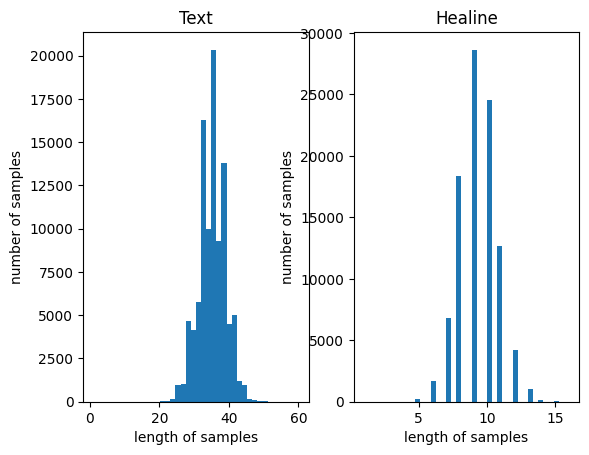

In [ ]:
#샘플 최대길이 지정

#최소, 최대, 평균 길이
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(1,2,2)
plt.title('Healines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#위 결과를 바탕으로  Text의 최대 길이와 Summary의 적절한 최대 길이 지정 
#훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

#계산
text_max_len = 50
summary_max_len = 13

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998577250231196
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981707502972531


In [ ]:
#text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외

data = data[data.apply(lambda x : len(x["text"].split()) <= text_max_len and len(x["headlines"].split()) <= summary_max_len, axis =1 )]
print('전체 샘플수 :', (len(data)))   #98,207


전체 샘플수 : 98207


In [17]:
"""
#전처리 데이터 csv로 저장
data.to_csv("after_max_news.csv", index = "False")
"""
"""
#after 전처리, 샘플길이 조절한 csv불러오기
data = pd.read_csv("after_max_news.csv")
data = data[['headlines', 'text']]   
print('전체 샘플수 :', (len(data)))   # 98207
data.head(2)
""

전체 샘플수 : 98207


,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...


In [18]:
# healines 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

#인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

data.head(2)

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...


훈련 데이터와 테스트 데이터를 분리

In [19]:
#샘플 shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
#전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)   #19,641

#정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))   #78,566
print('훈련 레이블의 개수 :', len(decoder_input_train))   #78,566
print('테스트 데이터의 개수 :', len(encoder_input_test))  #19,641
print('테스트 레이블의 개수 :', len(decoder_input_test))  #19,641

[58243  1261  6351 ... 27951 28149  8480]
테스트 데이터의 수 : 19641
훈련 데이터의 개수 : 78566
훈련 레이블의 개수 : 78566
테스트 데이터의 개수 : 19641
테스트 레이블의 개수 : 19641


단어 집합(vocabulary) & 희귀단어 제외 & 정수시퀀스 변환

In [20]:
#encoder_input_train

#토크나이저 정의 및 단어 집합 생성
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)   

#등장 빈도가 7회 미만인 단어 비중확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69635
등장 빈도가 6번 이하인 희귀 단어의 수: 47428
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22207
단어 집합에서 희귀 단어의 비율: 68.10942773030804
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4792313998911446


In [21]:
#단어 집합의 크기를 20,000으로 제한
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기 제한 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:1])

[[825, 79, 339, 361, 3230, 526, 271, 2056, 18451, 2622, 460, 79, 2057, 4851, 230, 17497, 460, 4333, 460, 6, 1037, 10699, 33, 12191, 1778, 1353, 1861, 162, 18451]]


In [22]:
#decoder_input_train

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30062
등장 빈도가 5번 이하인 희귀 단어의 수: 19626
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10436
단어 집합에서 희귀 단어의 비율: 65.2850775064866
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.648337714550797


In [23]:
#단어 집합의 크기를 10,000으로 제한
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:1])
print('target')
print('decoder ',decoder_target_train[:1])

input
input  [[1, 252, 2237, 4, 3166, 242]]
target
decoder  [[252, 2237, 4, 3166, 242, 2]]


In [24]:
#훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78566
훈련 레이블의 개수 : 78566
테스트 데이터의 개수 : 19640
테스트 레이블의 개수 : 19640


In [25]:
#패딩하기
text_max_len = 50
summary_max_len = 13

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

Step3. 어텐션 메커니즘 사용하기
>어텐션 메커니즘을 사용한 seq2seq

In [26]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256  #hidden state: LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터(용량의 크기 또는 뉴런의 개수라고 이해)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, 
#                      recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)


# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)



# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [27]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [ ]:
#모델훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 63s 165ms/step - loss: 5.4970 - val_loss: 5.1628
Epoch 2/50
307/307 [==============================] - 38s 124ms/step - loss: 5.1885 - val_loss: 5.0795
Epoch 3/50
307/307 [==============================] - 37s 119ms/step - loss: 5.0916 - val_loss: 4.9874
Epoch 4/50
307/307 [==============================] - 35s 116ms/step - loss: 4.9758 - val_loss: 4.8527
Epoch 5/50
307/307 [==============================] - 35s 116ms/step - loss: 4.8088 - val_loss: 4.6944
Epoch 6/50
307/307 [==============================] - 35s 115ms/step - loss: 4.6757 - val_loss: 4.6075
Epoch 7/50
307/307 [==============================] - 35s 114ms/step - loss: 4.5860 - val_loss: 4.5265
Epoch 8/50
307/307 [==============================] - 35s 113ms/step - loss: 4.4947 - val_loss: 4.4454
Epoch 9/50
307/307 [==============================] - 35s 114ms/step - loss: 4.4064 - val_loss: 4.3772
Epoch 10/50
307/307 [==============================] - 35s 114ms/step - l

In [ ]:
#모델 저장 (https://ssongnote.tistory.com/12)
from tensorflow.python.keras.models import load_model
model.save('model_230526.h5')

In [56]:
#모델 불러오기
"""
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
"""
model = load_model('model_230526.h5', compile=False)

인퍼런스 모델 구현

In [42]:
#테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
#필요한 3개의 사전
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

#인코더 모델과 디코더 모델을 분리해서 설계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
#어텐션 메커니즘을 사용하는 출력층을 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [44]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
#요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드
"""
Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 
Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외
"""

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환  
def seq2summary(input_seq):
    # [[YOUR CODE]]
    temp=''
    for i in input_seq:
        if((i!=0 and i!=['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + src_index_to_word[i]+' '
    return temp


Step4. 실제 결과와 요약문 비교하기

In [ ]:
#테스트 데이터 약 10개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

full = []
original = []
generated = []

for i in range(0, 11):
    full.append(seq2text(encoder_input_test[i]))
    original.append(seq2summary(decoder_input_test[i]))
    generated.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

In [103]:
results = pd.DataFrame({"full": full, "original": original, "generated": generated})
results

,full,original,generated
0,us president donald trump saturday explained d...,said last mountain old appearing first year pa...,buttler took aims aims principal cheap rss rs...
1,responding non bailable warrant issued maharas...,said girl people holiday hotel malik good base...,buttler road volkswagen buttler hub dancing m...
2,egypt education minister ordered students resp...,said run added triple year issued law council ...,buttler road buttler hub dancing madhuri da r...
3,airbnb host united states arrested couple alle...,said love close litre rai added drank also civ...,buttler road buttler volkswagen textbook trea...
4,delhi high court directed delhi government pos...,said former years awards year really scheduled...,buttler road buttler took screen snacks nose ...
5,slamming jammu kashmir cm mehbooba mufti sayin...,said based disappointed found state disappoint...,buttler buttler road interstellar epl bagh sm...
6,commenting comedy film housefull completing se...,said kya fir reports however calling sara pull...,buttler took aims aims principal cheap rss rs...
7,jammu kashmir chief minister mehbooba mufti tu...,said based disappointed beauty corporation ind...,buttler jerusalem darwin frivolous airasia si...
8,indian cricketer lokesh rahul posted picture g...,said members khan police largest court objecti...,buttler unique buttler sapna whatsapp conside...
9,karni sena chittorgarh unit president govind s...,said lal april saturday four minister sympathy...,buttler unique buttler sapna whatsapp conside...


Step5. Summa을 이용해서 추출적 요약해보기

In [83]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 샘플수 :', (len(data)))
data.head(3) 

전체 샘플수 : 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...


In [100]:
#summa를 이용한 추출적 요약
data["summa"] = data["text"].apply(lambda x: summarizer.summarize(x, words = 20))

In [101]:
data.head(10)

,headlines,text,summa
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",The program and upGrad's 360-degree career sup...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,India's previous lowest ODI total in New Zeala...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...,Congress candidate Shafia Zubair won the Ramga...
